# Analyse Pas-à-Pas de ComBat-GMM

Ce notebook reprend **exactement** l'implémentation ComBat-GMM utilisée dans le projet et ajoute des visualisations/commentaires détaillés pour comprendre chaque étape du flux : pré-traitement ComBat classique, estimation des mélanges gaussiens et transformation finale des résidus.


## 1. Dépendances et configuration

On importe les bibliothèques standard pour l'analyse numérique et la visualisation. Les visualisations sont configurées pour être reproductibles.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', context='talk')
np.random.seed(0)


## 2. Implémentation ComBat-GMM

La cellule ci-dessous contient **mot pour mot** le code Python de `clinical_combat/harmonization/QuickCombatGmm.py`.


In [2]:
# -*- coding: utf-8 -*-
"""ComBat-GMM harmonization method built on top of QuickCombatClassic."""
from typing import Dict, Tuple

import numpy as np
import pandas as pd

from clinical_combat.harmonization.QuickCombatClassic import QuickCombatClassic


class QuickCombatGmm(QuickCombatClassic):
    """Quick ComBat variant that aligns higher-order moments using Gaussian mixtures."""

    def __init__(
        self,
        bundle_names=None,
        model_params=None,
        ignore_sex_covariate: bool = False,
        ignore_handedness_covariate: bool = False,
        use_empirical_bayes: bool = True,
        limit_age_range: bool = False,
        degree: int = 1,
        regul_ref: float = 0,
        regul_mov: float = 0,
        alpha=None,
        beta=None,
        sigma=None,
        gamma_ref=None,
        delta_ref=None,
        gamma_mov=None,
        delta_mov=None,
        gmm_components: int = 2,
        gmm_tol: float = 1e-4,
        gmm_max_iter: int = 200,
    ):
        super().__init__(
            bundle_names=bundle_names,
            model_params=model_params,
            ignore_sex_covariate=ignore_sex_covariate,
            ignore_handedness_covariate=ignore_handedness_covariate,
            use_empirical_bayes=use_empirical_bayes,
            limit_age_range=limit_age_range,
            degree=degree,
            regul_ref=regul_ref,
            regul_mov=regul_mov,
            alpha=alpha,
            beta=beta,
            sigma=sigma,
            gamma_ref=gamma_ref,
            delta_ref=delta_ref,
            gamma_mov=gamma_mov,
            delta_mov=delta_mov,
        )
        self.gmm_components = max(1, int(gmm_components))
        self.gmm_tol = float(gmm_tol)
        self.gmm_max_iter = max(10, int(gmm_max_iter))
        self.gmm_params_ref: Dict[str, Dict[str, np.ndarray]] = {}
        self.gmm_params_mov: Dict[str, Dict[str, np.ndarray]] = {}

    def initialize_from_model_params(self, model_filename):
        super().initialize_from_model_params(model_filename)
        gmm_params = self.model_params.get("gmm")
        if gmm_params:
            self.gmm_components = int(gmm_params.get("components", self.gmm_components))
            self.gmm_tol = float(gmm_params.get("tol", self.gmm_tol))
            self.gmm_max_iter = int(gmm_params.get("max_iter", self.gmm_max_iter))
            self.gmm_params_ref = {
                str(bundle): {
                    "weights": np.array(vals["weights"], dtype=float),
                    "means": np.array(vals["means"], dtype=float),
                    "vars": np.array(vals["vars"], dtype=float),
                }
                for bundle, vals in gmm_params.get("ref", {}).items()
            }
            self.gmm_params_mov = {
                str(bundle): {
                    "weights": np.array(vals["weights"], dtype=float),
                    "means": np.array(vals["means"], dtype=float),
                    "vars": np.array(vals["vars"], dtype=float),
                }
                for bundle, vals in gmm_params.get("mov", {}).items()
            }

    def save_model(self, model_filename):
        self.model_params["name"] = "gmm"
        self.model_params["gmm"] = {
            "components": int(self.gmm_components),
            "tol": float(self.gmm_tol),
            "max_iter": int(self.gmm_max_iter),
            "ref": {
                bundle: {
                    "weights": params["weights"].tolist(),
                    "means": params["means"].tolist(),
                    "vars": params["vars"].tolist(),
                }
                for bundle, params in self.gmm_params_ref.items()
            },
            "mov": {
                bundle: {
                    "weights": params["weights"].tolist(),
                    "means": params["means"].tolist(),
                    "vars": params["vars"].tolist(),
                }
                for bundle, params in self.gmm_params_mov.items()
            },
        }
        super().save_model(model_filename)

    def set_model_fit_params(self, ref_data, mov_data):
        super().set_model_fit_params(ref_data, mov_data)
        self.model_params["name"] = "gmm"
        self.model_params["gmm"] = {
            "components": int(self.gmm_components),
            "tol": float(self.gmm_tol),
            "max_iter": int(self.gmm_max_iter),
            "ref": {
                bundle: {
                    "weights": params["weights"].tolist(),
                    "means": params["means"].tolist(),
                    "vars": params["vars"].tolist(),
                }
                for bundle, params in self.gmm_params_ref.items()
            },
            "mov": {
                bundle: {
                    "weights": params["weights"].tolist(),
                    "means": params["means"].tolist(),
                    "vars": params["vars"].tolist(),
                }
                for bundle, params in self.gmm_params_mov.items()
            },
        }

    def fit(self, ref_data, mov_data, HC_only=True):
        super().fit(ref_data, mov_data, HC_only)

        design_ref, y_ref = self.get_design_matrices(ref_data)
        design_mov, y_mov = self.get_design_matrices(mov_data)

        z_ref = self.standardize_moving_data(design_ref, y_ref)
        z_mov = self.standardize_moving_data(design_mov, y_mov)

        self.gmm_params_ref = {}
        self.gmm_params_mov = {}

        for idx, bundle in enumerate(self.bundle_names):
            params_ref = self._fit_gmm_bundle(z_ref[idx])
            params_mov = self._fit_gmm_bundle(z_mov[idx])
            self.gmm_params_ref[bundle] = params_ref
            self.gmm_params_mov[bundle] = params_mov

        self.set_model_fit_params(ref_data, mov_data)

    def apply(self, data):
        if not self.gmm_params_ref or not self.gmm_params_mov:
            raise AssertionError("GMM model parameters are not loaded.")

        design, Y = self.get_design_matrices(data)
        harm_y = []

        for i in range(len(design)):
            bundle = self.bundle_names[i]
            covariate_effect = (
                np.dot(design[i][1:, :].transpose(), self.beta[i])
                if design[i].shape[0] > 1
                else np.zeros(len(Y[i]))
            )

            z = (Y[i] - self.alpha[i] - covariate_effect) / self.sigma[i]

            params_mov = self.gmm_params_mov.get(bundle)
            params_ref = self.gmm_params_ref.get(bundle)

            if not params_mov or not params_ref or params_mov["weights"].size == 1:
                z_adj = z
            else:
                z_adj = self._transform_residuals(z, params_mov, params_ref)

            harm = z_adj * self.sigma[i] + self.alpha[i] + covariate_effect
            harm_y.append(harm)

        return harm_y

    def _fit_gmm_bundle(self, data: np.ndarray) -> Dict[str, np.ndarray]:
        data = np.asarray(data, dtype=float)
        data = data[np.isfinite(data)]
        if data.size <= 1:
            mean = np.array([float(data.mean()) if data.size else 0.0])
            var = np.array([float(data.var(ddof=0)) + 1e-6])
            return {"weights": np.array([1.0]), "means": mean, "vars": var}

        k = min(self.gmm_components, max(1, len(np.unique(data))))
        weights, means, vars_ = self._fit_gmm_1d(data, k)
        return {"weights": weights, "means": means, "vars": vars_}

    def _fit_gmm_1d(
        self, data: np.ndarray, components: int
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        values = np.asarray(data, dtype=float).flatten()
        n_samples = values.size

        if components == 1:
            mean = np.array([values.mean()])
            var = np.array([np.var(values) + 1e-6])
            return np.array([1.0]), mean, var

        quantiles = np.linspace(0, 1, components + 2)[1:-1]
        means = np.quantile(values, quantiles)
        vars_ = np.full(components, np.var(values) + 1e-6)
        weights = np.full(components, 1.0 / components)

        log_likelihood = -np.inf
        for _ in range(self.gmm_max_iter):
            resp, new_log_likelihood = self._gmm_expectation(values, weights, means, vars_)
            if np.abs(new_log_likelihood - log_likelihood) < self.gmm_tol:
                break
            log_likelihood = new_log_likelihood

            weights, means, vars_ = self._gmm_maximization(values, resp)

        return weights, means, vars_

    @staticmethod
    def _gmm_expectation(data, weights, means, vars_):
        eps = 1e-6
        sigmas = np.sqrt(np.maximum(vars_, eps))
        pdf = (
            weights[:, None]
            / (np.sqrt(2 * np.pi) * sigmas[:, None])
            * np.exp(-0.5 * ((data[None, :] - means[:, None]) / sigmas[:, None]) ** 2)
        )
        total = pdf.sum(axis=0, keepdims=True)
        total = np.clip(total, eps, None)
        resp = pdf / total
        log_likelihood = np.sum(np.log(total))
        return resp, log_likelihood

    @staticmethod
    def _gmm_maximization(data, resp):
        eps = 1e-6
        nk = resp.sum(axis=1) + eps
        weights = nk / resp.shape[1]
        means = (resp @ data) / nk
        diff = data[None, :] - means[:, None]
        vars_ = np.sum(resp * (diff ** 2), axis=1) / nk + eps
        return weights, means, vars_

    @staticmethod
    def _transform_residuals(z, params_mov, params_ref):
        eps = 1e-6
        weights = params_mov["weights"]
        means_mov = params_mov["means"]
        vars_mov = np.maximum(params_mov["vars"], eps)

        means_ref = params_ref["means"]
        vars_ref = np.maximum(params_ref["vars"], eps)

        sig_mov = np.sqrt(vars_mov)
        sig_ref = np.sqrt(vars_ref)

        pdf = (
            weights[:, None]
            / (np.sqrt(2 * np.pi) * sig_mov[:, None])
            * np.exp(-0.5 * ((z[None, :] - means_mov[:, None]) / sig_mov[:, None]) ** 2)
        )
        total = pdf.sum(axis=0, keepdims=True)
        total = np.clip(total, eps, None)
        resp = pdf / total

        adjusted = (
            (z[None, :] - means_mov[:, None]) / sig_mov[:, None] * sig_ref[:, None]
            + means_ref[:, None]
        )
        return np.sum(resp * adjusted, axis=0)


## 3. Jeu de données synthétique

On construit un exemple jouet avec deux bundles (`b1`, `b2`). Le site de référence suit une distribution gaussienne standard, tandis que le site moving contient une composante additionnelle qui génère un biais de moyenne et de variance.


In [3]:
def make_synthetic_data(n_ref=80, n_mov=120, bundles=('b1', 'b2')):
    rows_ref, rows_mov = [], []
    for sid in range(n_ref):
        age = np.random.uniform(20, 70)
        for b in bundles:
            rows_ref.append({
                'sid': f'ref_{sid}',
                'bundle': b,
                'mean': np.random.normal(loc=0.0, scale=1.0),
                'age': age,
                'disease': 'HC',
                'handedness': 1,
                'sex': 1,
                'site': 'RefSite',
                'metric': 'fa'
            })
    for sid in range(n_mov):
        age = np.random.uniform(25, 75)
        for b in bundles:
            center = 1.5 if b == 'b1' else -1.0
            scale = 1.8 if sid % 2 == 0 else 0.8
            rows_mov.append({
                'sid': f'mov_{sid}',
                'bundle': b,
                'mean': np.random.normal(loc=center, scale=scale),
                'age': age,
                'disease': 'HC',
                'handedness': 2,
                'sex': 2,
                'site': 'MovSite',
                'metric': 'fa'
            })
    return pd.DataFrame(rows_ref), pd.DataFrame(rows_mov)

ref_df, mov_df = make_synthetic_data()
ref_df.head()


,sid,bundle,mean,age,disease,handedness,sex,site,metric
0,ref_0,b1,0.741592,47.440675,HC,1,1,RefSite,fa
1,ref_0,b2,1.552914,47.440675,HC,1,1,RefSite,fa
2,ref_1,b1,1.867558,47.244159,HC,1,1,RefSite,fa
3,ref_1,b2,-0.977278,47.244159,HC,1,1,RefSite,fa
4,ref_2,b1,1.266119,41.879361,HC,1,1,RefSite,fa


## 4. Visualisation initiale des distributions

On compare les distributions par bundle avant harmonisation (moyennes brutes).


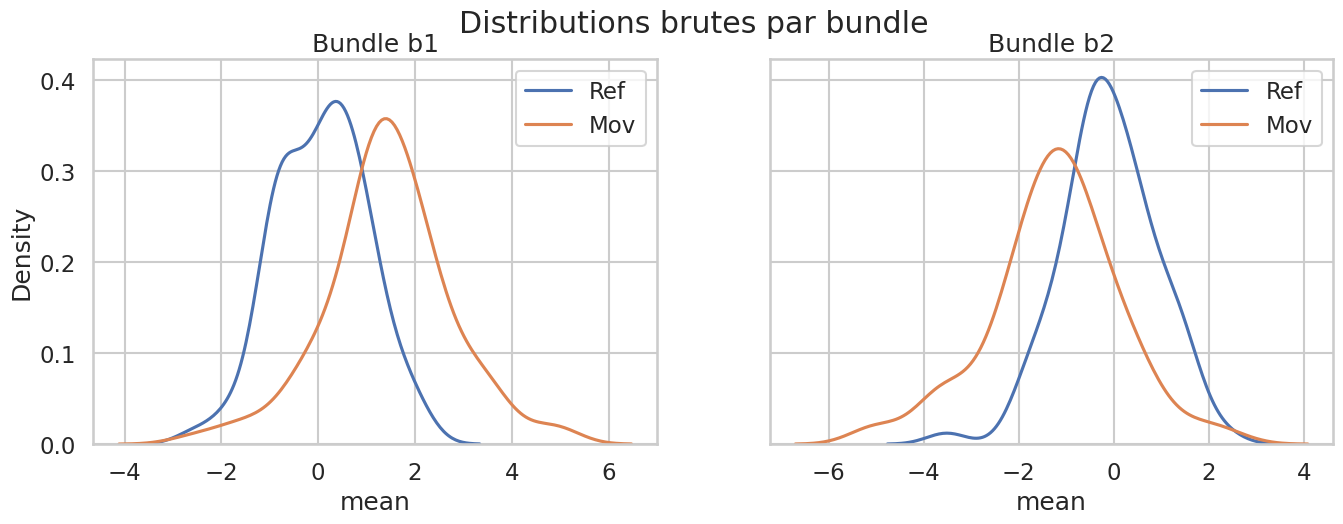

In [4]:
def plot_raw_distributions(ref_df, mov_df, feature='mean'):
    fig, axes = plt.subplots(1, len(ref_df.bundle.unique()), figsize=(16, 5), sharey=True)
    if len(ref_df.bundle.unique()) == 1:
        axes = [axes]
    for ax, bundle in zip(axes, ref_df.bundle.unique()):
        sns.kdeplot(ref_df.loc[ref_df.bundle == bundle, feature], label='Ref', ax=ax)
        sns.kdeplot(mov_df.loc[mov_df.bundle == bundle, feature], label='Mov', ax=ax)
        ax.set_title(f"Bundle {bundle}")
        ax.legend()
    fig.suptitle('Distributions brutes par bundle')
    plt.show()

plot_raw_distributions(ref_df, mov_df)


## 5. Ajustement ComBat-GMM pas-à-pas

On instancie le modèle, on effectue l'ajustement et on inspecte les paramètres clés (poids, moyennes et variances des mélanges).


In [5]:
from clinical_combat.harmonization import from_model_name

qc = from_model_name('gmm', gmm_components=2, gmm_tol=1e-5, gmm_max_iter=300)
qc.fit(ref_df.copy(), mov_df.copy())

qc.gmm_params_mov


{'b1': {'weights': array([0.61145599, 0.38854403]),
  'means': array([0.37774898, 0.4264319 ]),
  'vars': array([1.40549886, 0.1971662 ])},
 'b2': {'weights': array([0.63598553, 0.36401449]),
  'means': array([-0.36468392, -0.26191365]),
  'vars': array([1.54516218, 0.16340358])}}

### 5.1 Préparation des données utilisées par ComBat

On réutilise la fonction `prepare_data` héritée de ComBat classique pour vérifier quelles lignes sont conservées et dans quel ordre les bundles sont traités.


In [6]:
ref_prep, mov_prep = qc.prepare_data(ref_df.copy(), mov_df.copy(), HC_only=True)
print(f'Ref préparé: {ref_prep.shape[0]} lignes | Mov préparé: {mov_prep.shape[0]} lignes')
display(ref_prep.head())


Ref préparé: 160 lignes | Mov préparé: 240 lignes


,sid,bundle,mean,age,disease,handedness,sex,site,metric
0,ref_0,b1,0.741592,47.440675,HC,1,1,RefSite,fa
1,ref_0,b2,1.552914,47.440675,HC,1,1,RefSite,fa
2,ref_1,b1,1.867558,47.244159,HC,1,1,RefSite,fa
3,ref_1,b2,-0.977278,47.244159,HC,1,1,RefSite,fa
20,ref_10,b1,0.566440,50.604786,HC,1,1,RefSite,fa


### 5.2 Matrices de design et vecteurs de mesures

La méthode `get_design_matrices` construit la matrice des covariables (intercept, sexe, latéralité, terme d'âge) bundle par bundle. On inspecte les dimensions pour chaque bundle.


In [13]:
design_ref, y_ref = qc.get_design_matrices(ref_prep)
design_mov, y_mov = qc.get_design_matrices(mov_prep)
for bundle, X_ref, y_ref_b, X_mov, y_mov_b in zip(qc.bundle_names, design_ref, y_ref, design_mov, y_mov):
    print(f'Bundle {bundle}: design_ref {X_ref.shape} | y_ref {y_ref_b.shape} | design_mov {X_mov.shape} | y_mov {y_mov_b.shape}')


Bundle b1: design_ref (2, 80) | y_ref (80,) | design_mov (2, 120) | y_mov (120,)
Bundle b2: design_ref (2, 80) | y_ref (80,) | design_mov (2, 120) | y_mov (120,)


### 5.3 Résidus standardisés par site

On reproduit les résidus utilisés par la GMM : standardisation ComBat à partir des paramètres `alpha`, `beta`, `sigma`.


In [8]:
z_ref = qc.standardize_moving_data(design_ref, y_ref)
z_mov = qc.standardize_moving_data(design_mov, y_mov)
for bundle, z_r, z_m in zip(qc.bundle_names, z_ref, z_mov):
    print(f'Bundle {bundle}: résidus ref -> mean {np.mean(z_r):.3f}, std {np.std(z_r):.3f} | résidus mov -> mean {np.mean(z_m):.3f}, std {np.std(z_m):.3f}')


Bundle b1: résidus ref -> mean -0.595, std 0.702 | résidus mov -> mean 0.397, std 0.968
Bundle b2: résidus ref -> mean 0.491, std 0.720 | résidus mov -> mean -0.327, std 1.022


### 5.4 Paramètres de mélange gaussien détaillés

On assemble les poids, moyennes et variances pour chaque composante et chaque bundle afin de visualiser le transfert effectué par ComBat-GMM.


In [9]:
rows = []
for bundle in qc.bundle_names:
    params_mov = qc.gmm_params_mov[bundle]
    params_ref = qc.gmm_params_ref[bundle]
    k = len(params_mov['weights'])
    for i in range(k):
        rows.append({
            'bundle': bundle,
            'component': i,
            'weight_mov': params_mov['weights'][i],
            'mean_mov': params_mov['means'][i],
            'var_mov': params_mov['vars'][i],
            'mean_ref': params_ref['means'][i],
            'var_ref': params_ref['vars'][i]
        })
param_df = pd.DataFrame(rows)
display(param_df)


,bundle,component,weight_mov,mean_mov,var_mov,mean_ref,var_ref
0,b1,0,0.611456,0.377749,1.405499,-0.774309,0.624286
1,b1,1,0.388544,0.426432,0.197166,-0.498022,0.394605
2,b2,0,0.635986,-0.364684,1.545162,-1.994334,0.000001
3,b2,1,0.364014,-0.261914,0.163404,0.522367,0.446309


### 5.5 Projection composante par composante

On calcule explicitement la transformation appliquée aux résidus du site moving : chaque composante est recentrée et rescalée vers la composante correspondante du site référence.


In [10]:
bundle = qc.bundle_names[0]
subset = mov_prep[mov_prep.bundle == bundle]
X_mov, y_mov_bundle = qc.get_design_matrices(subset)
z_mov_bundle = qc.standardize_moving_data(X_mov, y_mov_bundle)[0]

params_mov = qc.gmm_params_mov[bundle]
params_ref = qc.gmm_params_ref[bundle]

def transform_residuals(z, params_mov, params_ref):
    eps = 1e-6
    weights = params_mov['weights']
    means_mov = params_mov['means']
    vars_mov = np.maximum(params_mov['vars'], eps)
    means_ref = params_ref['means']
    vars_ref = np.maximum(params_ref['vars'], eps)
    sig_mov = np.sqrt(vars_mov)
    sig_ref = np.sqrt(vars_ref)
    pdf = (
        weights[:, None]
        / (np.sqrt(2 * np.pi) * sig_mov[:, None])
        * np.exp(-0.5 * ((z[None, :] - means_mov[:, None]) / sig_mov[:, None]) ** 2)
    )
    total = pdf.sum(axis=0, keepdims=True)
    total = np.clip(total, eps, None)
    resp = pdf / total
    adjusted = ((z[None, :] - means_mov[:, None]) / sig_mov[:, None] * sig_ref[:, None] + means_ref[:, None])
    return np.sum(resp * adjusted, axis=0), resp

z_trans, responsibilities = transform_residuals(z_mov_bundle, params_mov, params_ref)
print(f'Avant transformation: mean {np.mean(z_mov_bundle):.3f}, std {np.std(z_mov_bundle):.3f}')
print(f'Après transformation : mean {np.mean(z_trans):.3f}, std {np.std(z_trans):.3f}')


Avant transformation: mean 0.397, std 0.968
Après transformation : mean -0.667, std 0.717


## 6. Visualisation des composantes GMM estimées

On superpose la densité empirique des résidus standardisés avec les composantes gaussiennes apprises pour le site moving afin de visualiser la décomposition mixture -> reference.


In [11]:
def plot_gmm_components(qc, mov_df, bundle='b1'):
    subset = mov_df[mov_df.bundle == bundle]
    if subset.empty:
        print(f"Aucune donnée pour le bundle {bundle}.")
        return

    design_mov, y_mov = qc.get_design_matrices(subset)
    if not design_mov:
        print(f"Impossible de construire la matrice de design pour {bundle}.")
        return

    z_lists = qc.standardize_moving_data(design_mov, y_mov)
    if not z_lists or len(z_lists[0]) == 0:
        print(f"Résidus vides pour {bundle}.")
        return
    z_mov = z_lists[0]

    params_mov = qc.gmm_params_mov.get(bundle)
    params_ref = qc.gmm_params_ref.get(bundle)
    if params_mov is None or params_ref is None:
        print(f"Paramètres GMM introuvables pour {bundle}.")
        return

    xs = np.linspace(z_mov.min() - 2, z_mov.max() + 2, 400)
    mov_pdf = np.zeros_like(xs)
    ref_pdf = np.zeros_like(xs)
    for w, m, v in zip(params_mov['weights'], params_mov['means'], params_mov['vars']):
        mov_pdf += w * (1/np.sqrt(2*np.pi*v)) * np.exp(-0.5*((xs-m)**2)/v)
    for w, m, v in zip(params_mov['weights'], params_ref['means'], params_ref['vars']):
        ref_pdf += w * (1/np.sqrt(2*np.pi*v)) * np.exp(-0.5*((xs-m)**2)/v)

    plt.figure(figsize=(10,5))
    sns.histplot(z_mov, stat='density', bins=30, label='Résidus mov', color='tab:orange', alpha=0.3)
    plt.plot(xs, mov_pdf, label='Mixture mov (estimée)', color='tab:red')
    plt.plot(xs, ref_pdf, label='Mixture cible ref (reprojetée)', color='tab:blue', linestyle='--')
    plt.title(f"Décomposition GMM pour le bundle {bundle}")
    plt.legend()
    plt.show()


## 7. Application et visualisation post-harmonisation

On applique la transformation ComBat-GMM et on compare les distributions harmonisées aux distributions du site de référence.


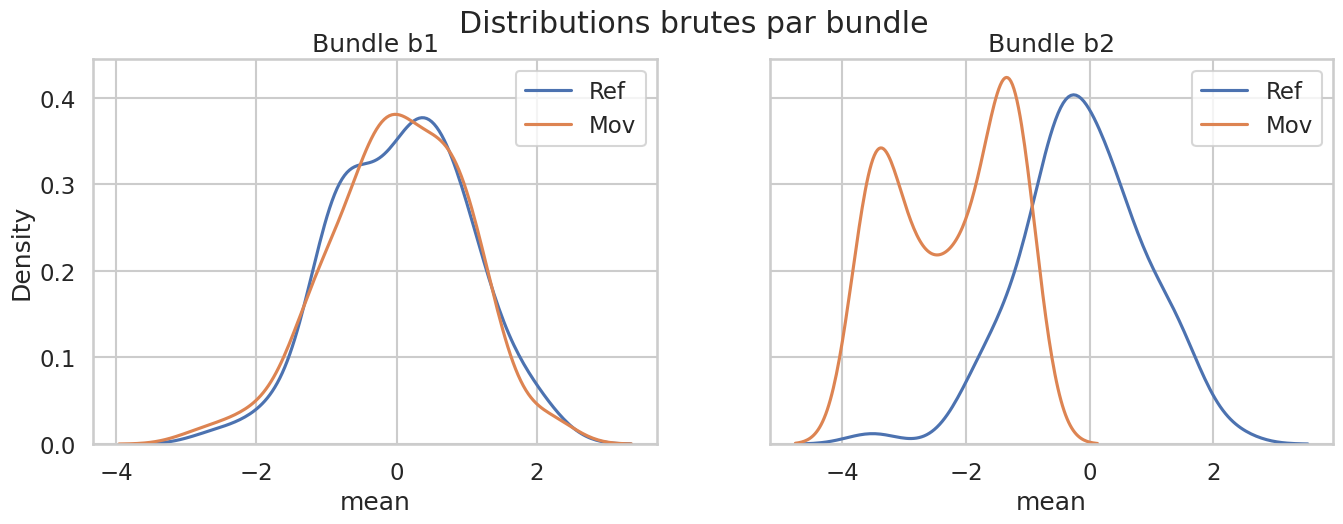

In [12]:
harm_df = mov_df.copy()
for bundle, values in zip(qc.bundle_names, qc.apply(mov_df.copy())):
    mask = harm_df.bundle == bundle
    harm_df.loc[mask, 'mean'] = values

plot_raw_distributions(ref_df, harm_df)


## 8. Résumé

Ce notebook illustre :

1. **ComBat classique** pour aligner moyennes/variances (hérité de `QuickCombatClassic`).
2. **Ajustement GMM** sur les résidus standardisés (site ref et moving).
3. **Transfert des moments supérieurs** en reprojetant les composantes du moving vers celles du référence.
4. **Visualisations** pour inspecter les distributions brutes, les mélanges estimés et le résultat harmonisé.
